# Задача 10. Graph Convolutional Network



## Задача

- Найти графовый набор данных для решения задачи предсказания (классификация вершин, обнаружение сообществ и т.д.).
- Использовать несколько слоев GCNConv из библиотеки PyG для построения GCN модели.
- Обучить полученную модель, подобрать гиперпараметры (например, learning rate) на валидационной выборке, и оценить качество предсказания на тестовой выборке.
- (+5 баллов) Также представить самостоятельную реализацию слоя GCNConv, используя матричные операции. Повторить обучение с собственными слоями и сравнить результаты.

Для выполнения задания был выбран набор данных Cora, который содержит научные публикации, разбитые на 7 тематических классов. Цель задачи – классификация вершин (определение тематики статьи).



Описание датасета:

*The Cora dataset is a well-known benchmark dataset in the field of graph-based machine learning. It represents a citation network of scientific publications. In the Cora dataset, nodes correspond to scientific papers, and edges represent citations between papers. Each paper is associated with a category or topic, and the task is to classify each paper into one of these categories based on the citation relationships and textual content of the papers. It's a common dataset used to evaluate graph-based machine learning models for tasks like node classification.*

## Набор данных

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00


In [55]:
import collections
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
from torch_geometric.utils import add_self_loops, degree

In [4]:
dataset = Planetoid(root='/content/cora', name='Cora')
data = dataset[0]

Processing...
Done!


In [56]:
data.num_nodes, data.num_edges

(2708, 10556)

In [57]:
dataset.num_classes

7

Можем посмотреть распределение значений целевой переменной

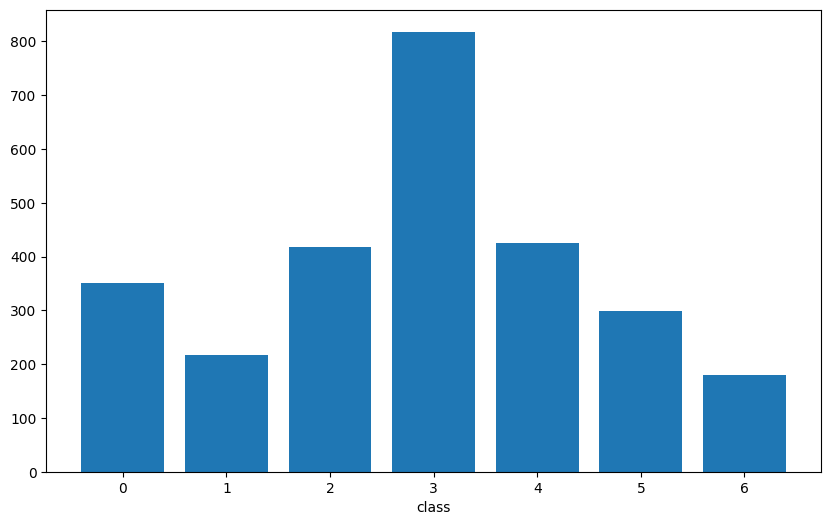

In [39]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=10)
plt.show()

In [21]:
data.has_isolated_nodes()

False

In [22]:
data.has_self_loops()

False

In [23]:
data.is_undirected()

True

,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


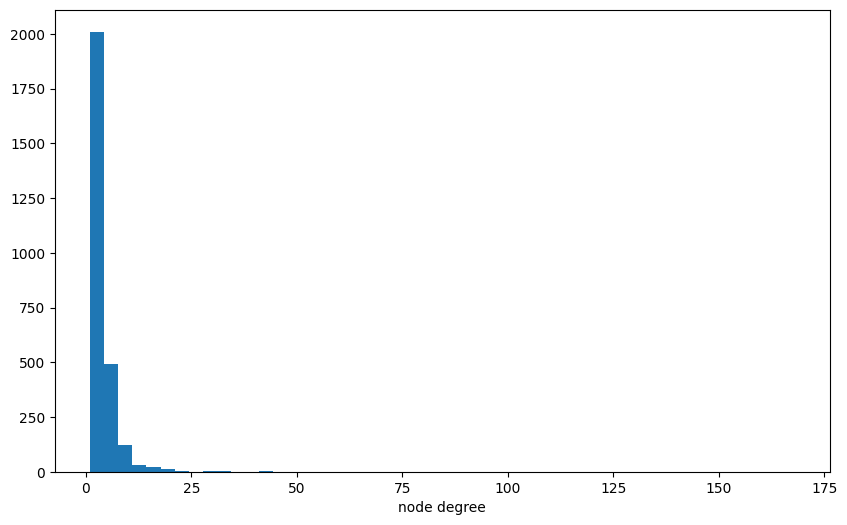

In [29]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

Высокая степень вершины означает, что она связана со многими узлами (статьями).

Можно предположить, что узлы (вершины) с высокой степенью, скорее всего, будут важны, так как статья, которую много раз цитировали, вероятно, хорошая


## Построение GCN модели

In [58]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(dataset.num_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [59]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        acc = (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()
    return acc

## Обучение с подбором гиперпараметров

In [60]:
best_val_acc = 0
best_lr = 0.01

for lr in [0.1, 0.01, 0.001]:
    optimizer.param_groups[0]['lr'] = lr
    for epoch in range(200):
        train()
    val_acc = evaluate(data.val_mask)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_lr = lr

optimizer.param_groups[0]['lr'] = best_lr
for epoch in range(200):
    train()

test_acc = evaluate(data.test_mask)
print(f'Test Accuracy (PyG): {test_acc:.4f}')

Test Accuracy (PyG): 0.8090


## Самостоятельная реализация GCNConv и обучение

In [61]:
class MyGCNConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels, bias=False)
        self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        row, col = edge_index

        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        adj = torch.sparse_coo_tensor(edge_index, norm, (x.size(0), x.size(0)))
        x = torch.sparse.mm(adj, x)
        x = self.lin(x)
        x += self.bias
        return x

In [62]:
class MyGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = MyGCNConv(input_dim, hidden_dim)
        self.conv2 = MyGCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [63]:
model = MyGCN(dataset.num_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [64]:
best_val_acc = 0
best_lr = 0.01

for lr in [0.1, 0.01, 0.001]:
    optimizer.param_groups[0]['lr'] = lr
    for epoch in range(200):
        train()
    val_acc = evaluate(data.val_mask)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_lr = lr

optimizer.param_groups[0]['lr'] = best_lr
for epoch in range(200):
    train()

test_acc = evaluate(data.test_mask)
print(f'Test Accuracy (PyG): {test_acc:.4f}')

Test Accuracy (PyG): 0.8060


## Вывод

Обе модели показали близкие результаты, что подтверждает корректность самостоятельной реализации